In [2]:
!pip install openbrewerydb
!pip install iso3166

#TODO: Introduction to project

In [0]:
from bs4 import BeautifulSoup
import collections
from collections import Counter
import csv
import folium
from folium.plugins import MarkerCluster
import iso3166
import json
import matplotlib.pyplot as plt
import numpy as np
import openbrewerydb
import pandas as pd
import plotly.graph_objects as go
import requests
import re
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text 
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import fcluster
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn import neighbors, datasets
import string
from string import digits

In [0]:
import warnings
warnings.filterwarnings('ignore')

#TODO: explain this is our scraping code, and what sources this code came from

In [0]:
def load_openbrew():
  #load up breweries, this takes a few minutes to run
  data = openbrewerydb.load()
  return data

In [6]:
openbrew_df = load_openbrew()
display(openbrew_df)

id                      name  ...                updated_at tag_list
0        2       Avondale Brewing Co  ...  2018-08-23T23:19:57.825Z       []
1       44          Trim Tab Brewing  ...  2018-08-23T23:20:31.423Z       []
2       46      Yellowhammer Brewery  ...  2018-08-23T23:20:33.102Z       []
3       55  Bearpaw River Brewing Co  ...  2018-08-23T23:20:40.743Z       []
4       76    King Street Brewing Co  ...  2018-08-23T23:20:57.179Z       []
...    ...                       ...  ...                       ...      ...
8024  7923   Public Craft Brewing Co  ...  2018-08-24T16:44:56.034Z       []
8025  7958     Stevens Point Brewery  ...  2018-08-24T16:45:45.320Z       []
8026  7973      Titletown Brewing Co  ...  2018-08-24T16:46:06.736Z       []
8027  8000    Black Tooth Brewing Co  ...  2018-08-24T16:46:40.667Z       []
8028  8007  Gillette Brewing Company  ...  2018-08-24T16:46:48.215Z       []

[8029 rows x 14 columns]

#TODO: Beer Advocate

In [0]:
def load_ba_top_country(country='at'):
  #create url for each country, and parse accordingly
  url = "https://www.beeradvocate.com/beer/top-rated/" + country + '/'
  soup = BeautifulSoup(requests.get(url).text)
  best_beers = soup.findAll('tr')
  data = []
  for i in range(1, len(best_beers)):
    row = best_beers[i].findAll('td')
    data_row = []
    link = best_beers[i].findAll('a', href=True)[0]['href']
    for j in range(len(row)):
      if not (j == 0) and not (j == 4):
        data_row.append(row[j].get_text(separator='|'))
    data_row.append(country)
    data_row.append('https://www.beeradvocate.com' + link)
    data.append(data_row)
  return pd.DataFrame(data, columns=["text", "num_ratings", "avg_rating", "country", "links"])

def load_ba_top():
  #takes a while to run as well
  total = []
  #iterate through all country codes and then get the top by country in one dataframe
  for c in iso3166.countries_by_alpha2:
      total.append(load_ba_top_country(country=c.lower()))
  return pd.concat(total)
  
def process_ba_top_data(df):
  new = df.text.str.split('|', expand = True)
  df['drink_name'] = new[0]
  df['brewery'] = new[1]
  df['drink_type'] = new[2]
  df['abv'] = new[4].str.rstrip('%').astype(float)
  out = df.drop(columns =["text"])
  return out

def get_links(names):
  reg_tag = re.compile("/beer/profile/\d+/\d+/")
  out = []
  def get_url(name):
      req = requests.get('https://www.beeradvocate.com/search/?q='+ name.lower() +'&qt=beer')
      soup = BeautifulSoup(req.text, 'html.parser')
      tags = soup.findAll('a' , attrs={'href': reg_tag})
      for link in tags:
          return 'https://www.beeradvocate.com' + link.get('href')
      return None
  for n in names:
    tmp = get_url(n)
    out.append(tmp)
  return out

def get_rating(links):
  out = []
  for l in links:
    if l is not None:
      req = requests.get(l)
      soup = BeautifulSoup(req.text, 'html.parser')
      out.append(float(soup.findAll('span', {'class': 'ba-ravg Tooltip'})[0].text))
    else:
      out.append(None)
  return out

def get_reviews(links):
  out = []
  for l in links:
    if l is not None:
       req = requests.get(l)
       soup = BeautifulSoup(req.text, 'html.parser')
       row = []
       total = 0
       for t in soup.findAll('div', {'id': 'rating_fullview_content_2'}):
         tmp = re.sub("overall: [0-9].?[0-9]+", "", t.text.split('|')[-1], count=1)
         tmp = re.sub("overall: [0-9]", "", tmp, count=1)
         if total > 4000:
           break
         total += len(tmp)
         row.append(tmp)
       if total > 1000:
         out.append(row)
       else:
         out.append(None)
  return out

#TODO:  explain brewerydb 

In [0]:
def beerdata():
  url = "https://sandbox-api.brewerydb.com/v2/beers/?key=ff48dc71c860b607d027eb706155aa47"
  r1= requests.get(url)
  d = json.loads(r1.content)
  pages = d['numberOfPages']
  data1=[]
  for i in range(pages):
    params = {'p':i}
    r1= requests.get(url, params=params)
    d1 = json.loads(r1.content)
    data1.append(d1['data'])   
  
  ###this will take 10-15 seconds to run 
  beers=[]
  ####iterating over each inner list which is each page, and then iterating over the list of 50 dictionaries which is the actual beers
  for i in range(len(data1)):
    for j in range(len(data1[i])):
      beer = data1[i][j].copy()
      if 'style' in data1[i][j].keys():
        b1 = beer['style'].copy() #for unrolling as style itself is a dict
        b1.pop('category', None)
        b1.pop('createDate',None)
        b1.pop('shortName',None)
        b1['type_description'] = b1.pop('description')
        b1['style_name'] = b1.pop('name')
      else:
        b1 = {}
      keysToRemove = ('labels','available','availableId','createDate', 'isRetired','nameDisplay','updateDate','year','status','statusDisplay','style','glass','updateDate')
      for k in keysToRemove:
        beer.pop(k, None)
      a1 = {j:k for j,k in beer.items()}
      a1.update(b1)
      beers.append(a1)       
  return pd.DataFrame(beers)

In [9]:
beers_set = beerdata()
cols_delete = ['servingTemperatureDisplay', 'originalGravity', 'servingTemperature', 'updateDate', 'srmId', 'srm', 'ogMax', 'glasswareId', 'foodPairings']
for col in cols_delete:
  del beers_set[col]
display(beers_set)

id  ...  ibu
0      98  ...  NaN
1     164  ...   35
2      25  ...   45
3       5  ...  NaN
4      35  ...  NaN
...   ...  ...  ...
1145   65  ...   20
1146   33  ...   82
1147   52  ...  NaN
1148  136  ...  NaN
1149  124  ...  NaN

[1150 rows x 19 columns]

#TODO: Explain loading from CSV

--- 
linear reg

In [0]:
dataset = pd.read_csv('beers_set.csv')
# delete columns we don't need for linear regression
del dataset['Unnamed: 0']
del dataset['description']
del dataset['name']
del dataset['style_name']
del dataset['type_description']
del dataset['categoryId']
del dataset['id']
del dataset['styleId']

# convert isOrganic string Y/N to int 1/0 for linear regression
dataset.isOrganic.replace(('Y', 'N'), (1, 0), inplace=True)

# drop rows with NaN
dataset = dataset.dropna(how='any')

Let's now visualize our dataset and see some statistics.

In [76]:
dataset.head()

abv  abvMax  abvMin  fgMax  ...  ogMin  srmMax  srmMin  ratings
2    5.5     5.6     4.5  1.014  ...  1.044    14.0     6.0     3.97
7   10.0    10.0     7.0  1.018  ...  1.070     9.0     4.0     3.94
12   6.5     7.5     6.3  1.018  ...  1.060    14.0     6.0     3.88
17   7.9     6.5     4.8  1.016  ...  1.044    20.0    12.0     3.99
25   5.4     5.6     4.5  1.014  ...  1.044    14.0     6.0     3.66

[5 rows x 13 columns]

In [77]:
# see some stats for our dataset
dataset.describe()

abv      abvMax      abvMin  ...      srmMax      srmMin     ratings
count  353.000000  353.000000  353.000000  ...  353.000000  353.000000  353.000000
mean     6.835581    7.573371    5.455382  ...   18.325779   10.830028    3.840057
std      2.007492    2.311637    1.444199  ...   11.700517   11.676973    0.316257
min      3.200000    3.400000    0.500000  ...    2.000000    2.000000    1.780000
25%      5.400000    5.600000    4.500000  ...   13.000000    4.000000    3.650000
50%      6.300000    7.500000    5.300000  ...   14.000000    6.000000    3.870000
75%      8.000000    8.800000    6.300000  ...   22.000000   11.000000    4.050000
max     20.000000   12.000000    8.400000  ...   50.000000   40.000000    4.550000

[8 rows x 13 columns]

Before we move on to the fancy parts of linear regression and analysis, let's see how the ratings are distributed.

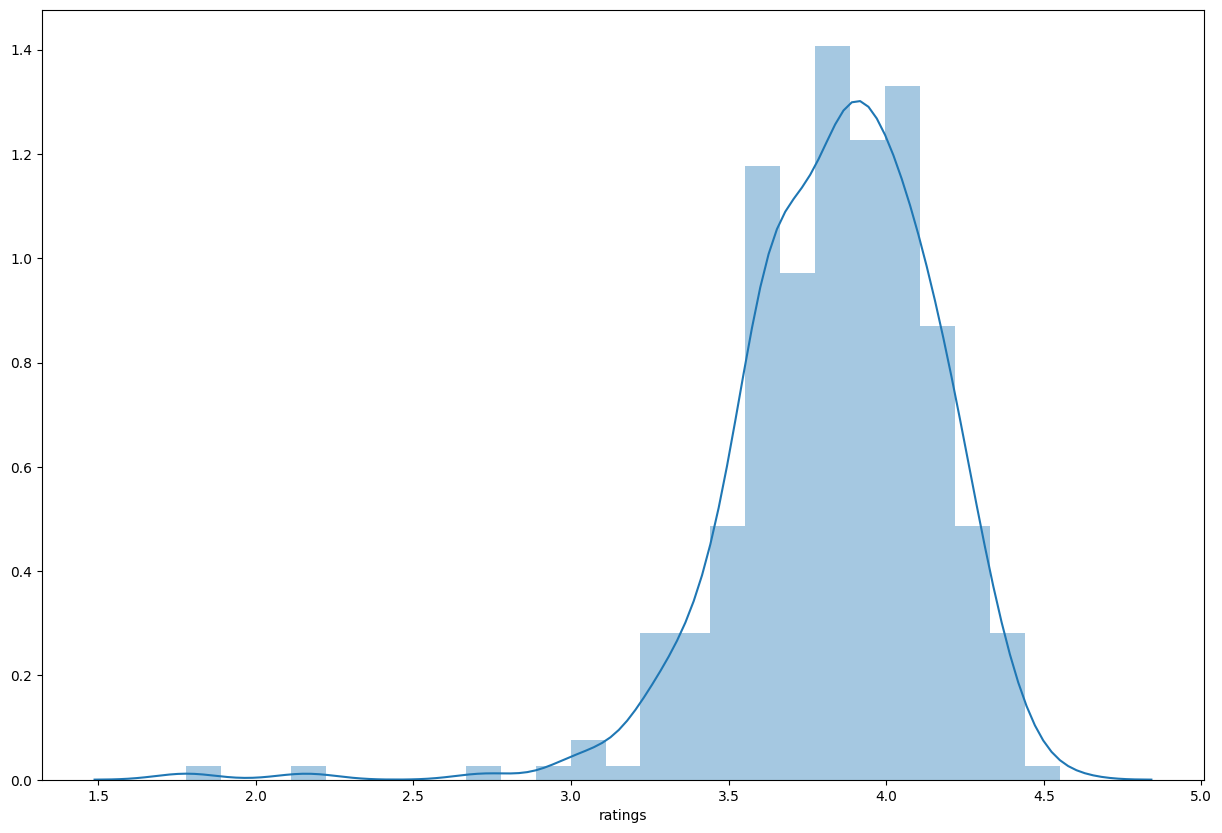

In [78]:
# histogram of beer ratings 
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(dataset['ratings'])

From the histogram above, we see that most ratings lie between 3.5 and 4.5 out of 5.0. This isn't very surprising as you'd expect most people to assign ratings in this range. Only in extreme circumstances would people give ratings like a 0 or 1.0 out of 5.0 e.g. if the beer was horrible! Interestingly, we don't see any 5.0 rating. In fact, if you take a look at the statistics table above, you see that the highest rating we have for a beer in our dataset is a 4.55. 

Okay, now let's move on to linear regression. We are going to try to use the features of a beer to predict its rating. We first divide our dataset into attributes/features and labels. For linear regression, we will use the `LinearRegression` model from `sklearn`. Notice that we are not normalizing our features here. This is becasue `LinearRegression` uses ordinary least squares. Ordinary least squares is invariant - for invariant methods there is no real need for standardization, while for non-invariant methods you probably need it. 

In [0]:
# divide dataset into attributes X and labels Y
X = dataset[['abv', 'abvMax', 'abvMin', 'fgMax', 'fgMin', 'ibu', 'ibuMax', 'ibuMin', 'isOrganic', 'ogMin', 'srmMax', 'srmMin']].values
y = dataset['ratings'].values

Now, we split our dataset into a train set (80%) and test set (20%). 

In [0]:
# split into train (80%) and test (20%) set
# set random_state if you want reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We now fit our train data to the `LinearRegression` model. Let's use our model to predict on the test set and see how our predicted values compare to the ground truth. 

In [82]:
# train model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
# predict on test set
y_pred = regressor.predict(X_test)
# let's see some actual vs. predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(10)

Actual  Predicted
0    4.04   4.101464
1    4.13   4.055953
2    3.35   3.607601
3    3.51   3.742747
4    3.91   3.694872
5    4.22   4.096273
6    3.57   3.701637
7    3.75   3.994710
8    3.95   3.857280
9    3.72   3.804279

#TODO: explain chart

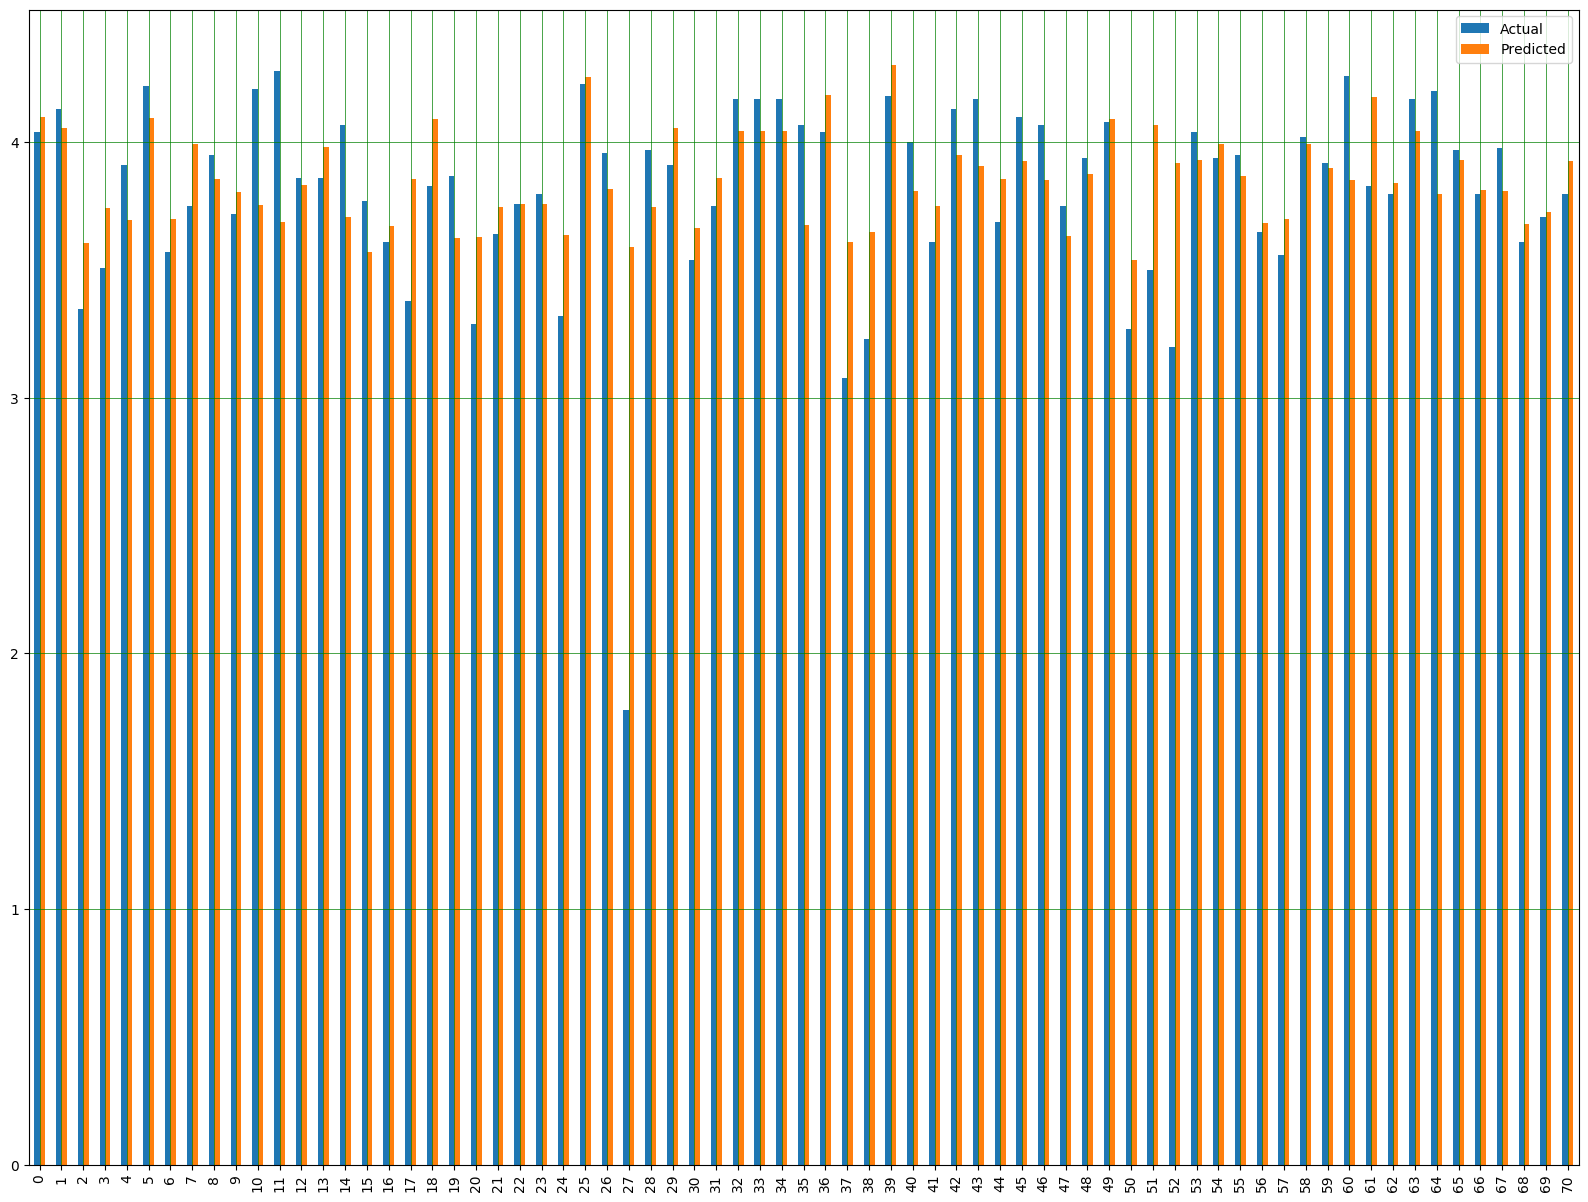

In [83]:
# plot comparison of actual vs. predicted values
df.plot(kind='bar',figsize=(20,15))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Finally, let's analyze some metrics of our model.

In [85]:
# see performance metrics of our model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# the lower the value is, the better the fit
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# the closer towards 1, the better the fit
print('R^2 score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.21130907715896796
Mean Squared Error: 0.10518333452856723
Root Mean Squared Error: 0.3243198028621861
R^2 score: 0.2567243825019011


Initially, linear regression does an mediocre job at predicting beer ratings. We achieve an R2 score of about 25% which means that our model can explain about 25% of the variability in beer ratings. This is far from ideal and clearly, we can improve. We now visualize every attribute/feature against beer rating to identify any correlations and then try to model only using these features to see if we can improve model performance. 

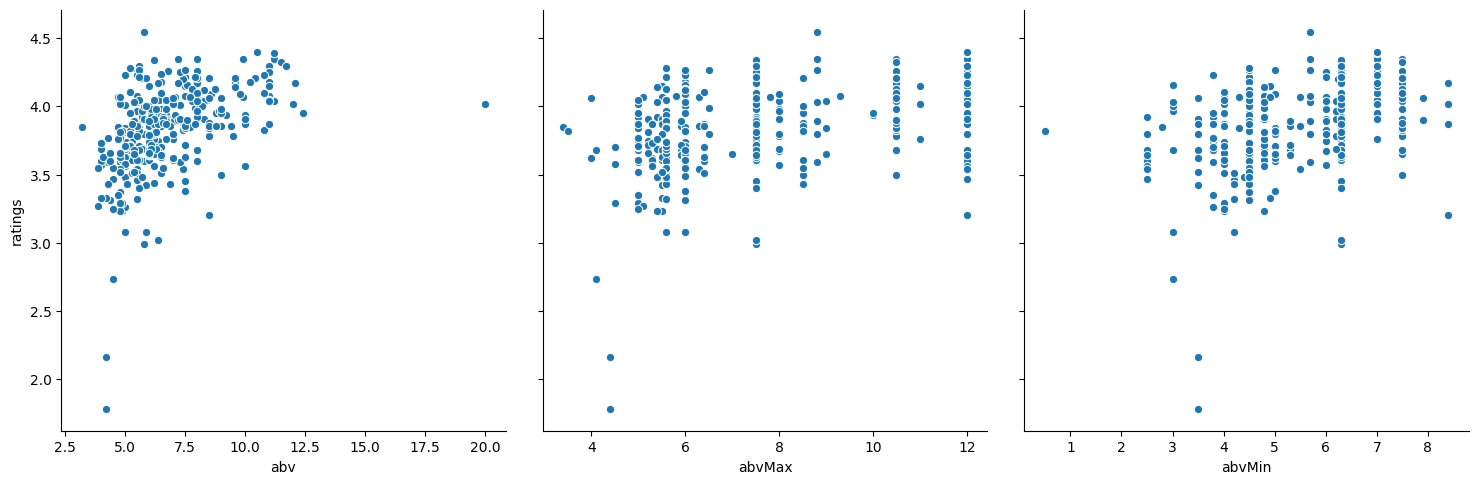

In [87]:
# visualize the relationship between the atributes/features and the label/target using scatterplots
sns.pairplot(dataset, x_vars=['abv', 'abvMax', 'abvMin'], y_vars='ratings', height=5)

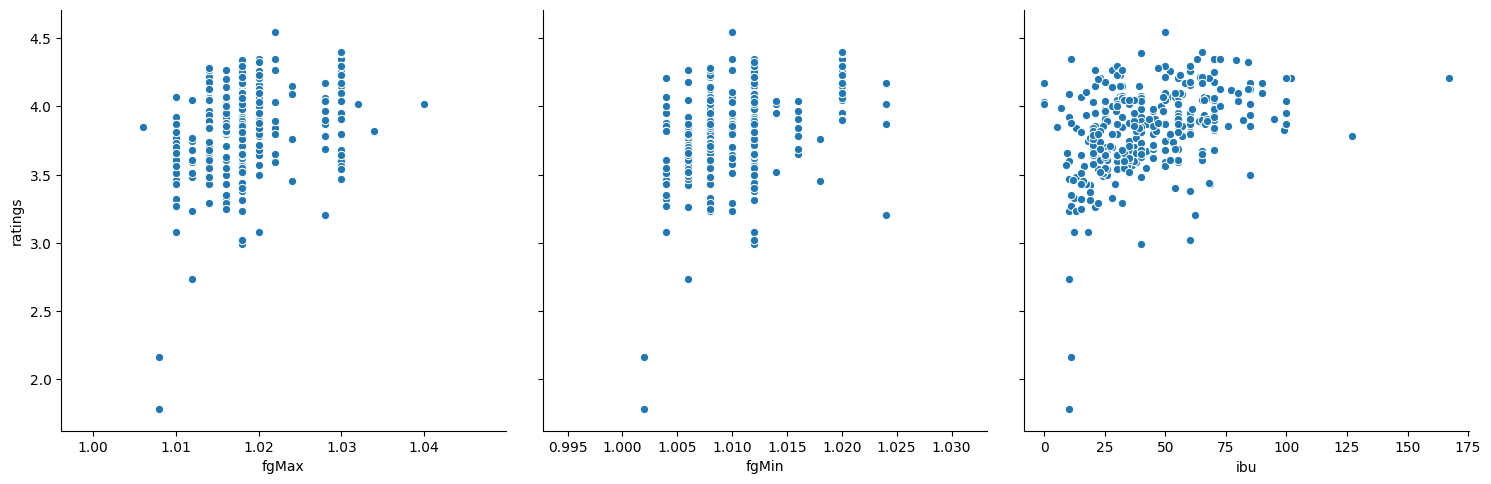

In [88]:
sns.pairplot(dataset, x_vars=['fgMax', 'fgMin', 'ibu'], y_vars='ratings', height=5)

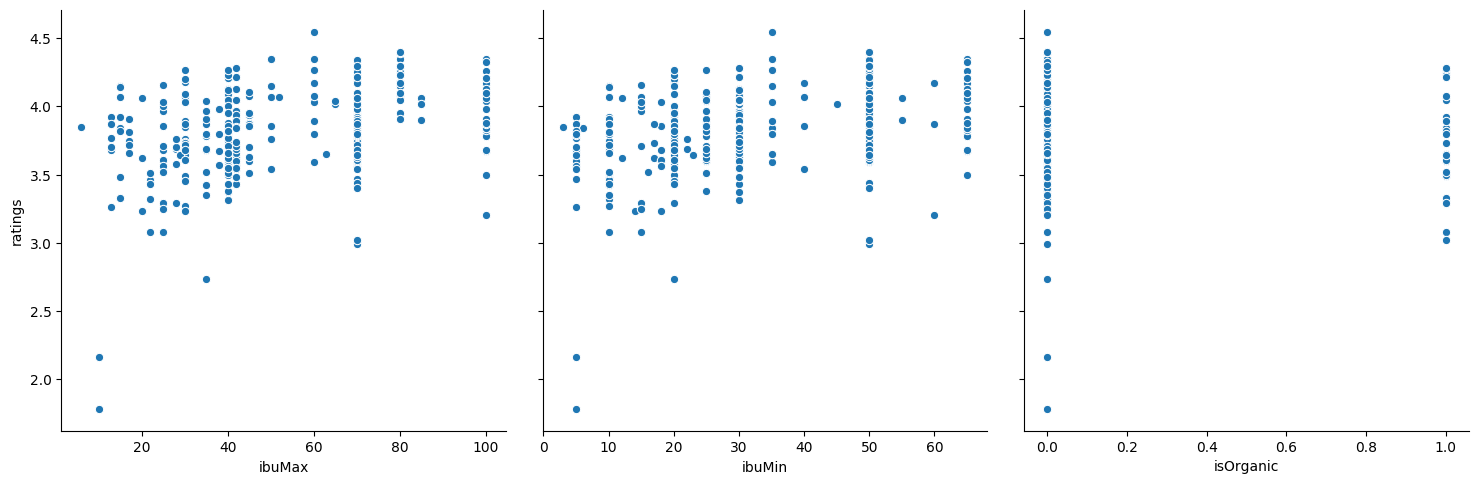

In [89]:
sns.pairplot(dataset, x_vars=['ibuMax', 'ibuMin', 'isOrganic'], y_vars='ratings', height=5)

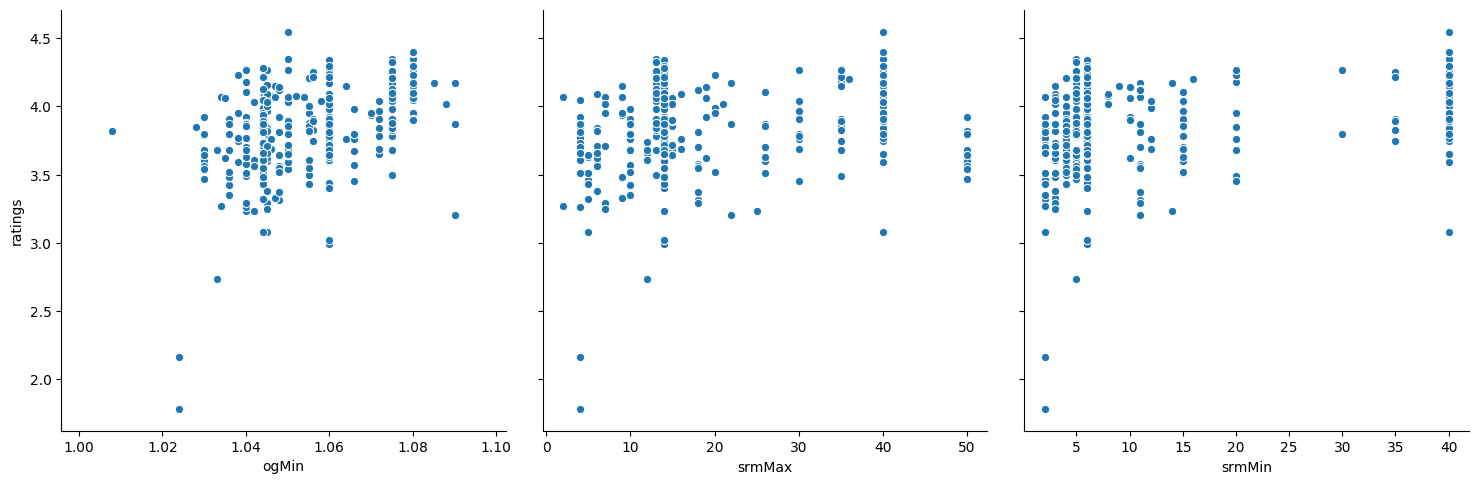

In [90]:
sns.pairplot(dataset, x_vars=['ogMin', 'srmMax', 'srmMin'], y_vars='ratings', height=5)

From the plots above, it is clear that `abv` and `ibu` have a heavy correlation with the rating of a beer. And it makes sense as one would expect the rating of the beer to be influenced by the alcohol by volume and its bitterness. To be sure, we will look at their `p scores`.

In [91]:
lm1 = smf.ols(formula='ratings ~ abv + abvMax + abvMin + fgMax + fgMin + ibu + ibuMax + ibuMin + isOrganic + ogMin + srmMax + srmMin', data=dataset).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ratings   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     14.33
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           3.56e-24
Time:                        20:36:05   Log-Likelihood:                -21.777
No. Observations:                 353   AIC:                             69.55
Df Residuals:                     340   BIC:                             119.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0561      6.257      0.488      0.626      -9.251      15.363
abv            0.0371      0.011      3.419      0.001       0.016       0.058
abvMax        -0.0207      0.033     -0.623      0.533      -0.086       0.045
abvMin         0.0184      0.038      0.483      0.630      -0.056       0.093
fgMax         13.1777      7.685      1.715      0.087      -1.938      28.294
fgMin        -18.7259      8.797     -2.129      0.034     -36.029      -1.423
ibu            0.0034      0.001      3.741      0.000       0.002       0.005
ibuMax        -0.0022      0.004     -0.562      0.575      -0.010       0.006
ibuMin         0.0019      0.005      0.376      0.707      -0.008       0.012
isOrganic     -0.0220      0.053     -0.411      0.682      -0.127       0.083
ogMin          5.6001      4.803      1.166      0.244      -3.848      15.048
srmMax         0.0025      0.004      0.688      0.492      -0.005       0.009
srmMin         0.0045      0.003      1.580      0.115      -0.001       0.010
==============================================================================
Omnibus:                      132.569   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              815.307
Skew:                          -1.438   Prob(JB):                    9.09e-178
Kurtosis:                       9.867   Cond. No.                     6.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Without getting into complex analysis, from the above table we can see that `abv` and `ibu` have low `p` values (< 0.05). This indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable. So now, we're confident that `abv` and `ibu` are the features that influence beer rating the most. The other features have high `p` values which indicate that they are poorly associated with the response variable i.e. beer ratings.

Now, we will build a linear regression model with only the `abv` and `ibu` features. Start by getting rid of all other features. Then, for `abv` and `ibu` features, ignore outliers becasue as we know, outliers significantly throw a linear regression model off. Once that is done, we build a new linear regression model just like we did above.

In [92]:
# work with only abv and ibu data & get rid of outliers
abv_ibu_data = dataset[(dataset.ibu < 110) & (dataset.abv < 13) & (dataset.ratings > 3.25)]

del abv_ibu_data['abvMax']
del abv_ibu_data['abvMin']
del abv_ibu_data['fgMax']
del abv_ibu_data['fgMin']
del abv_ibu_data['ibuMax']
del abv_ibu_data['ibuMin']
del abv_ibu_data['isOrganic']
del abv_ibu_data['ogMin']
del abv_ibu_data['srmMax']
del abv_ibu_data['srmMin']

abv_ibu_data.head()

abv   ibu  ratings
2    5.5  45.0     3.97
7   10.0  17.0     3.94
12   6.5  50.0     3.88
17   7.9   7.0     3.99
25   5.4  41.0     3.66

In [93]:
# divide dataset into attributes X and labels Y
X = abv_ibu_data[['abv', 'ibu']].values
y = abv_ibu_data['ratings'].values
# split into train (80%) and test (20%) set
# set random_state if you want reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# train model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
# predict on test set
y_pred = regressor.predict(X_test)
# let's see some actual vs. predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(10)

Actual  Predicted
0    3.70   3.808118
1    4.15   4.103411
2    3.64   3.808118
3    4.04   4.031320
4    3.77   3.665394
5    3.80   3.736501
6    3.94   4.001082
7    4.27   3.859919
8    3.70   3.819524
9    3.72   3.823156

#TODO: EXPLAIN PLOT

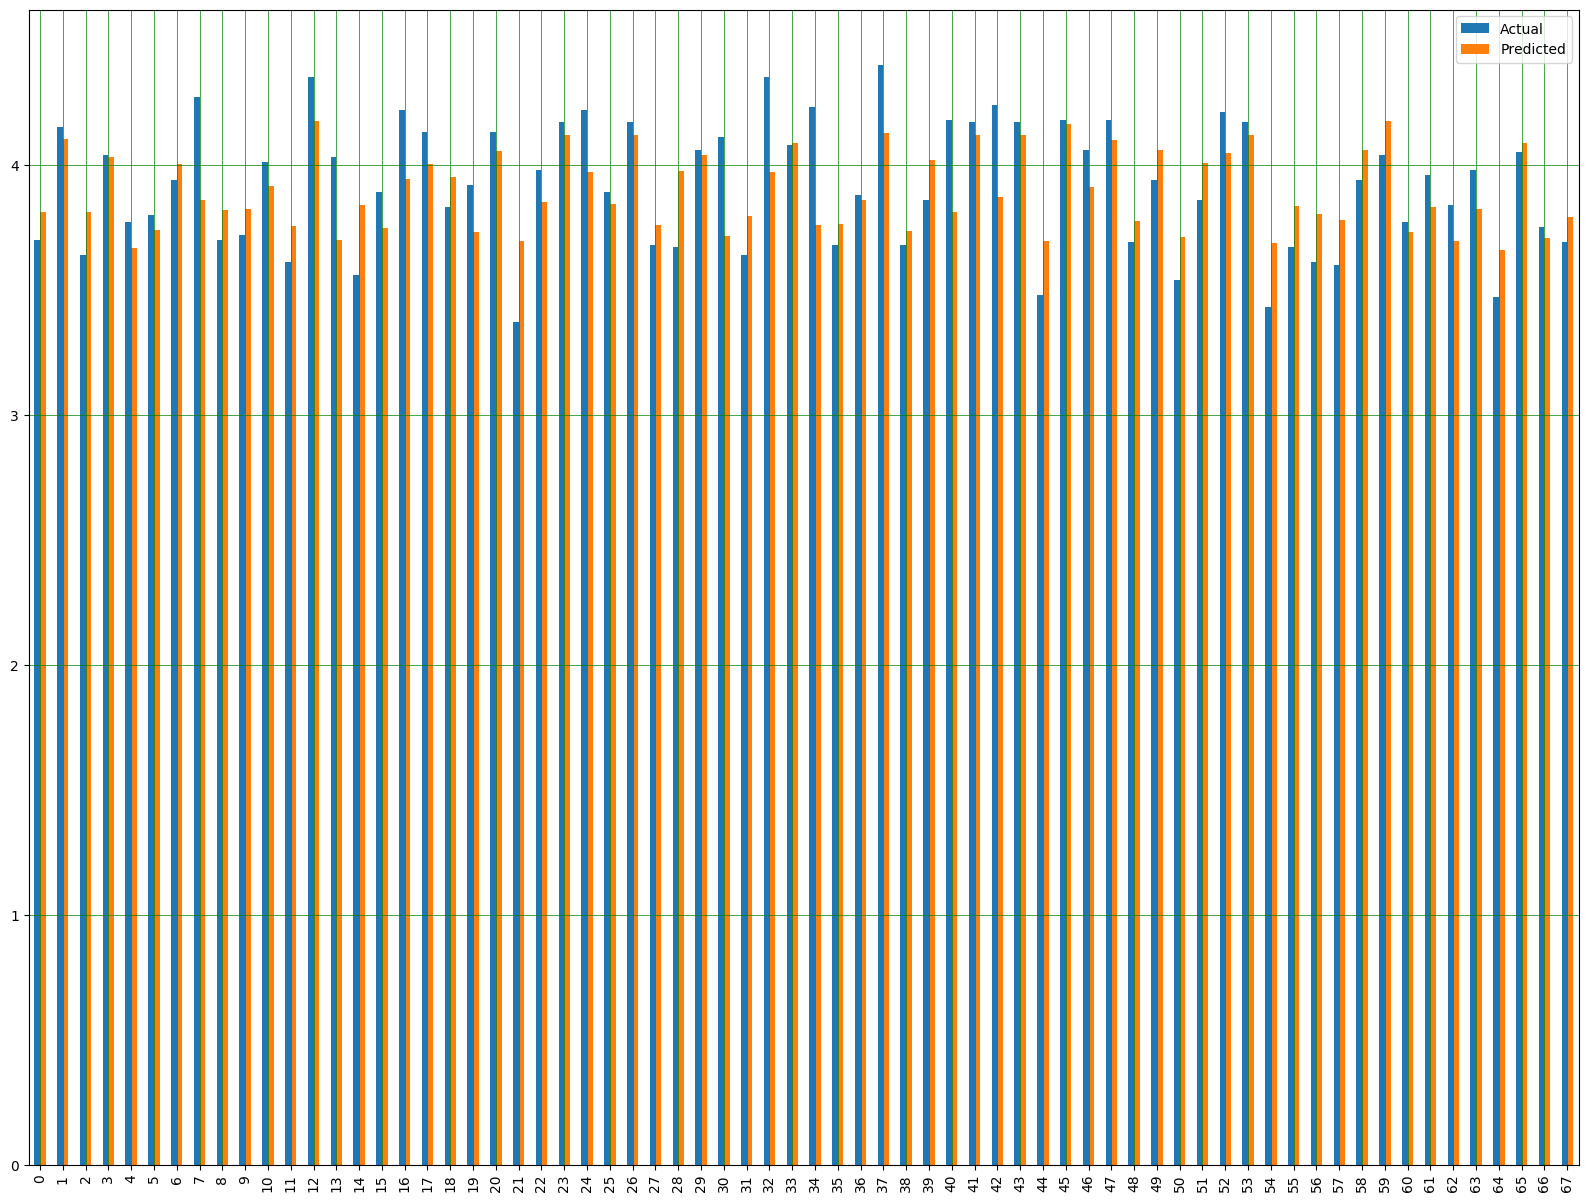

In [95]:
# plot comparison of actual vs. predicted values
df.plot(kind='bar',figsize=(20,15))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [96]:
# see performance metrics of our model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# the lower the value is, the better the fit
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# the closer towards 1, the better the fit
print('R^2 score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.15187662707830477
Mean Squared Error: 0.03503450494626649
Root Mean Squared Error: 0.18717506496931285
R^2 score: 0.4505688633407122


Here, we see the Root Mean Square Error significantly improve from the previous model. The R2 square also improves significantly - our model can now explain about 45% of the variability in beer ratings. 

We've now got some very interesting results. This goes to show you that feature selection is very important when building linear regression models. Often times, you will have many features that don't really add value to your model and in some cases, like ours, it can even hinder your model. 

In conclusion, while we made good progress from the first model to the second, we still can't say with enough confidence that linear regression does a good job at predicting beer ratings from the data we have. This makes sense because intuitively one can imagine how hard it might be to predict the rating of a beer in any meaningful sense especially with just alcohol by volume and bitterness.

#TODO: Explain loading from CSV

In [97]:
def load_ba_from_csv():
  return pd.read_csv('clean_ba_df.csv')

dataset = load_ba_from_csv()
display(dataset)

Unnamed: 0  ...                                            reviews
0              0  ...  [' Gold in color with a fingernail of eggshell...
1              1  ...  ['  oz bottle thanks to Jeremy. Typical euro p...
2              0  ...  [' A 250ml bottle brought back from Antigua by...
3              0  ...  [" Bold in character, rich with flare and dang...
4              1  ...  ["  ounce bottle (labeled Andean Stout). Serve...
...          ...  ...                                                ...
3959           3  ...  [' Not bad, not great. Dark Copper color. Good...
3960           4  ...  [' Looks like a pale ale, maybe a little light...
3961           5  ...  [' It pours amber with a small soft head. The ...
3962           0  ...  [" A 340ml bottle with an illegible BB date. G...
3963           0  ...  [" L- Notably 'yellow golden' rather than any ...

[3964 rows x 10 columns]

#Analyzing Reviews

As we can see the text is not fully ready for analysis. The next step is to pre process our text data in the reviews. This mainly involves converting all text to lower case, stripping out punctuations and digits, and lastly splitting the text into words which will be useful later as we will group by the beer type. We also append the words into a counter in order to get the distribution of words in our entire text data. This will be useful later for filtering out noise.

In [98]:
list2 = []
cnt=Counter()
for item in dataset['reviews']:
    item1 = item.strip('[')    
    item2 = item1.strip(']')
    item3 = item2.lower()
    item4 = item3.translate(str.maketrans('', '', string.punctuation))
    remove_digits = str.maketrans('', '', digits)
    res = item4.translate(remove_digits)
    item5 = res.split()     #doing this because for some reason python is treating the entire string as one word instead of a collection of words
    for word in item5:
        cnt[word] += 1
    list2.append(item5)
dataset['reviews'] = list2
dataset.head()

Unnamed: 0  ...                                            reviews
0           0  ...  [gold, in, color, with, a, fingernail, of, egg...
1           1  ...  [oz, bottle, thanks, to, jeremy, typical, euro...
2           0  ...  [a, ml, bottle, brought, back, from, antigua, ...
3           0  ...  [bold, in, character, rich, with, flare, and, ...
4           1  ...  [ounce, bottle, labeled, andean, stout, served...

[5 rows x 10 columns]

Our dataset is now ready with the reviews a collection of words. We have not yet however filtered out stopwords and incorrect words from our text. We also need to group the beers by beer type ('drink_type' column) as that is our variable of interest. We do both these steps below. We also filter our some additional words that are not representative of the characteristics of a beer but are instead generic adjectives like good, great, nice or generic beer words like hop, glass, beer, etc.

In [99]:
def get_rare_words(dist):    #Used this function from our homework where we did text analysis
    """use the word count information from the training data to find more stopwords

    args:
        dist: collections.Counter -- the cnt variable we created above

    returns : Set[str] -- a set of all words that appear less than or equal to 10 times in the training data
    """
    a = dict(dist)
    b = {k:v for (k,v) in a.items() if v<=10}
    c = set(b.keys())
    return c

stopwords_new = get_rare_words(cnt)

#define some other stopwords based on the specific data we are handling like beer, lager, hop, glass etc. as well 
# as some adjectives like good, nice, great which appear a lot.

other_stopwords = set(['beer', 'hop', 'beers', 'glass', 'head', 'good', 'like', 'ipa', 'body', 
                      'pretty', 'smells', 'smell', 'hops', 'alcohol', 'taste', 'lager', 'bit', 'light', 'malt', 
                      'dark', 'white', 'ale', 'quite', 'nice', 'bottle', 'pale', 'carbonation', 'bitterness', 
                      'just', 'little', 'really', 'lots', 'notes', 'ales', 'smoked', 'smokey', 'smoky', 'malts'])
stopwords_new = stopwords_new.union(other_stopwords)    #full list of stopwords

##group by drink type and aggregate all reviews
grp1 = dataset.groupby('drink_type', as_index=False).agg({'reviews':lambda x: list(x)})
list3=[]
for item in grp1['reviews']:
    item1 = sum(item, [])
    item2 = [w for w in item1 if not w in stopwords_new]
    item3 = [w for w in item2 if not w.startswith('character')]    #remove usernames which all begin with character
    item4 = " ".join(item3)
    list3.append(item4)
grp1['reviews'] = list3
grp1.head()

drink_type                                            reviews
0      American Adjunct Lager  a ml brought back from by friends although it ...
1    American Amber / Red Ale  a the is clear red in color and has a amount o...
2  American Amber / Red Lager  bright amber lively thin yet lasting foamy the...
3         American Barleywine  medium to amber in color with a high degree of...
4          American Black Ale  pitch black with no visible only a hint of a c...

We are now ready! We create a tfidf feature for our reviews all of them grouped by the beer type!


Now we can visualise the results. What are the most common words consumers use to describe each beer type? Can we see the most characteristic words for each style? For example, are Stouts defined by the flavor "coffee" and do IPAs generally have a "citrus" feel?

Do reviewers talk different about Pilsners than Lagers ?

We use the tf-idf scores to see this! Term Frequency-Inverse Document Frequency, or TF-IDF is a statistic used to identify keywords in each document by normalizing the word by the amount of times it appears in all documents. In essence it looks for words that are more frequent in a document but rare in all other documents. Those words are then good indicators of the characteristic of that document.


In [0]:
vectorizer = TfidfVectorizer(stop_words='english', max_features = 10000)
X = vectorizer.fit_transform(grp1['reviews'])
ind1 = []
X = X.toarray()
terms2 = np.array(vectorizer.get_feature_names())
tfidfscorevalues=[]
for i in range(X.shape[0]):
    a1 = X[i,:].ravel().argsort()[-3:]  #where the 3 most common words for that beer are located
    tfidfscorevalues.append(X[i,:][a1])
    ind1.append(a1)    #where the 3 most common words is located

In [23]:
print("Top terms per beer type:")
print("="*50)
for i in range(0,10):
    beertype = grp1['drink_type'][i]
    print (beertype)
    print(terms2[ind1][i])
    print("_____________________________________________")

Top terms per beer type:
American Adjunct Lager
['sweet' 'adjunct' 'corn']
_____________________________________________
American Amber / Red Ale
['caramel' 'red' 'amber']
_____________________________________________
American Amber / Red Lager
['sweet' 'amber' 'caramel']
_____________________________________________
American Barleywine
['sweet' 'caramel' 'barleywine']
_____________________________________________
American Black Ale
['chocolate' 'coffee' 'black']
_____________________________________________
American Blonde Ale
['sweet' 'golden' 'blonde']
_____________________________________________
American Brett
['brettanomyces' 'brett' 'peat']
_____________________________________________
American Brown Ale
['caramel' 'sweet' 'brown']
_____________________________________________
American Cream Ale
['yellow' 'bogota' 'honey']
_____________________________________________
American Dark Wheat Ale
['got' 'buckwheat' 'funk']
_____________________________________________


Lots of interesting results. An even better way to see would be to plot the top words for a few beers. Let's do this for a particular subset of 10 of the common American beers. 

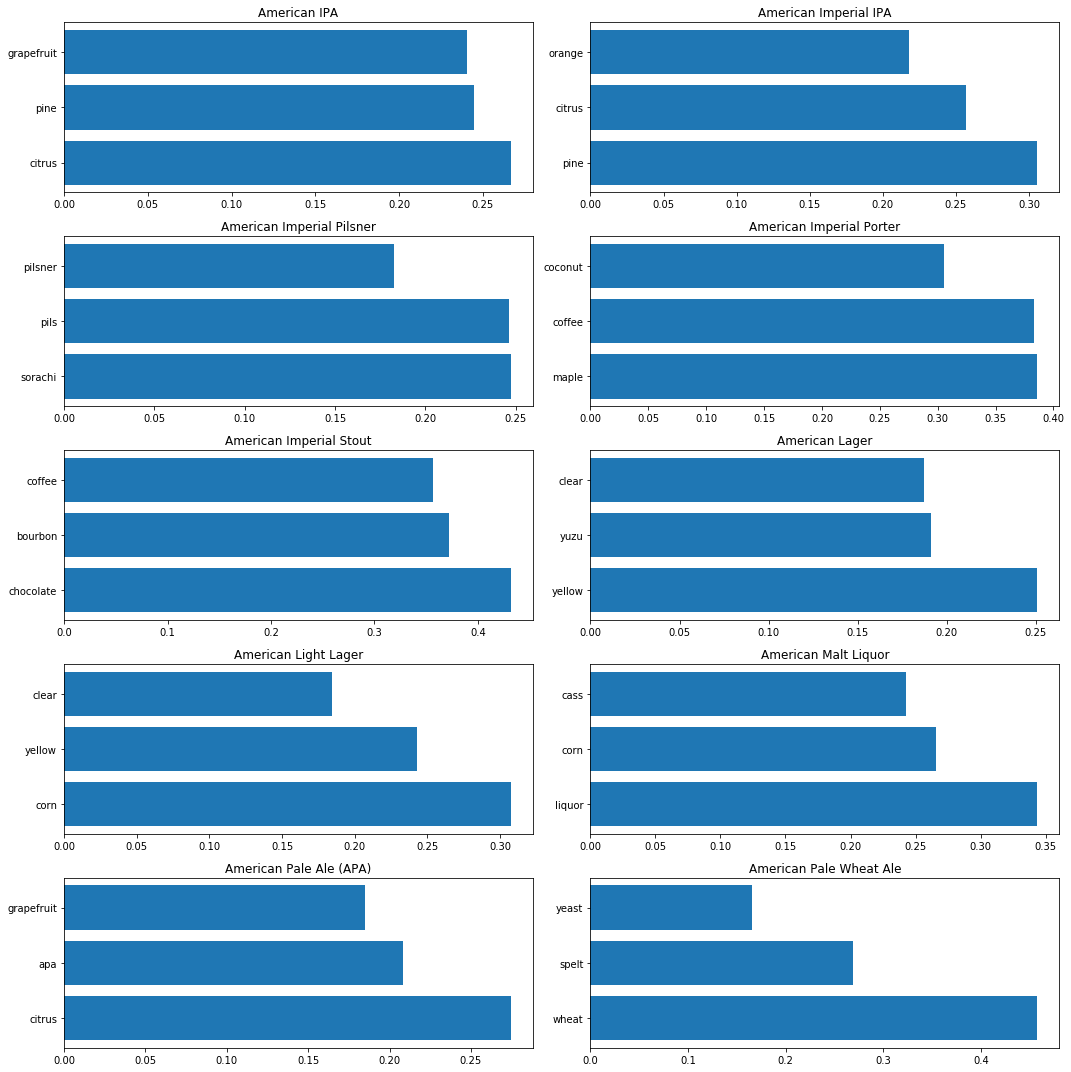

In [24]:
fig = plt.figure(figsize=(15, 15))
for i in range(10,20):
    ax = fig.add_subplot(5, 2, i-9)
    y_pos = np.arange(len(terms2[ind1][i]))
    ax.barh(y_pos, tfidfscorevalues[i], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(terms2[ind1][i])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(grp1['drink_type'][i])
plt.tight_layout()

Pretty cool right? We can now explore which beers are more similar to each other too, after all we have the key words and the tf-idf scores for each type of beer. Let's visualise this through a correlation matrix. First, we create the cosine similarity for x and then calculate it's correlation which essentially tells us how similar each row of our dataset (which in this case is each beer type) is to each other. We can then plot the correlation triange for the beers. We will do this for a subset of our data to keep the size of the plot reasonable.



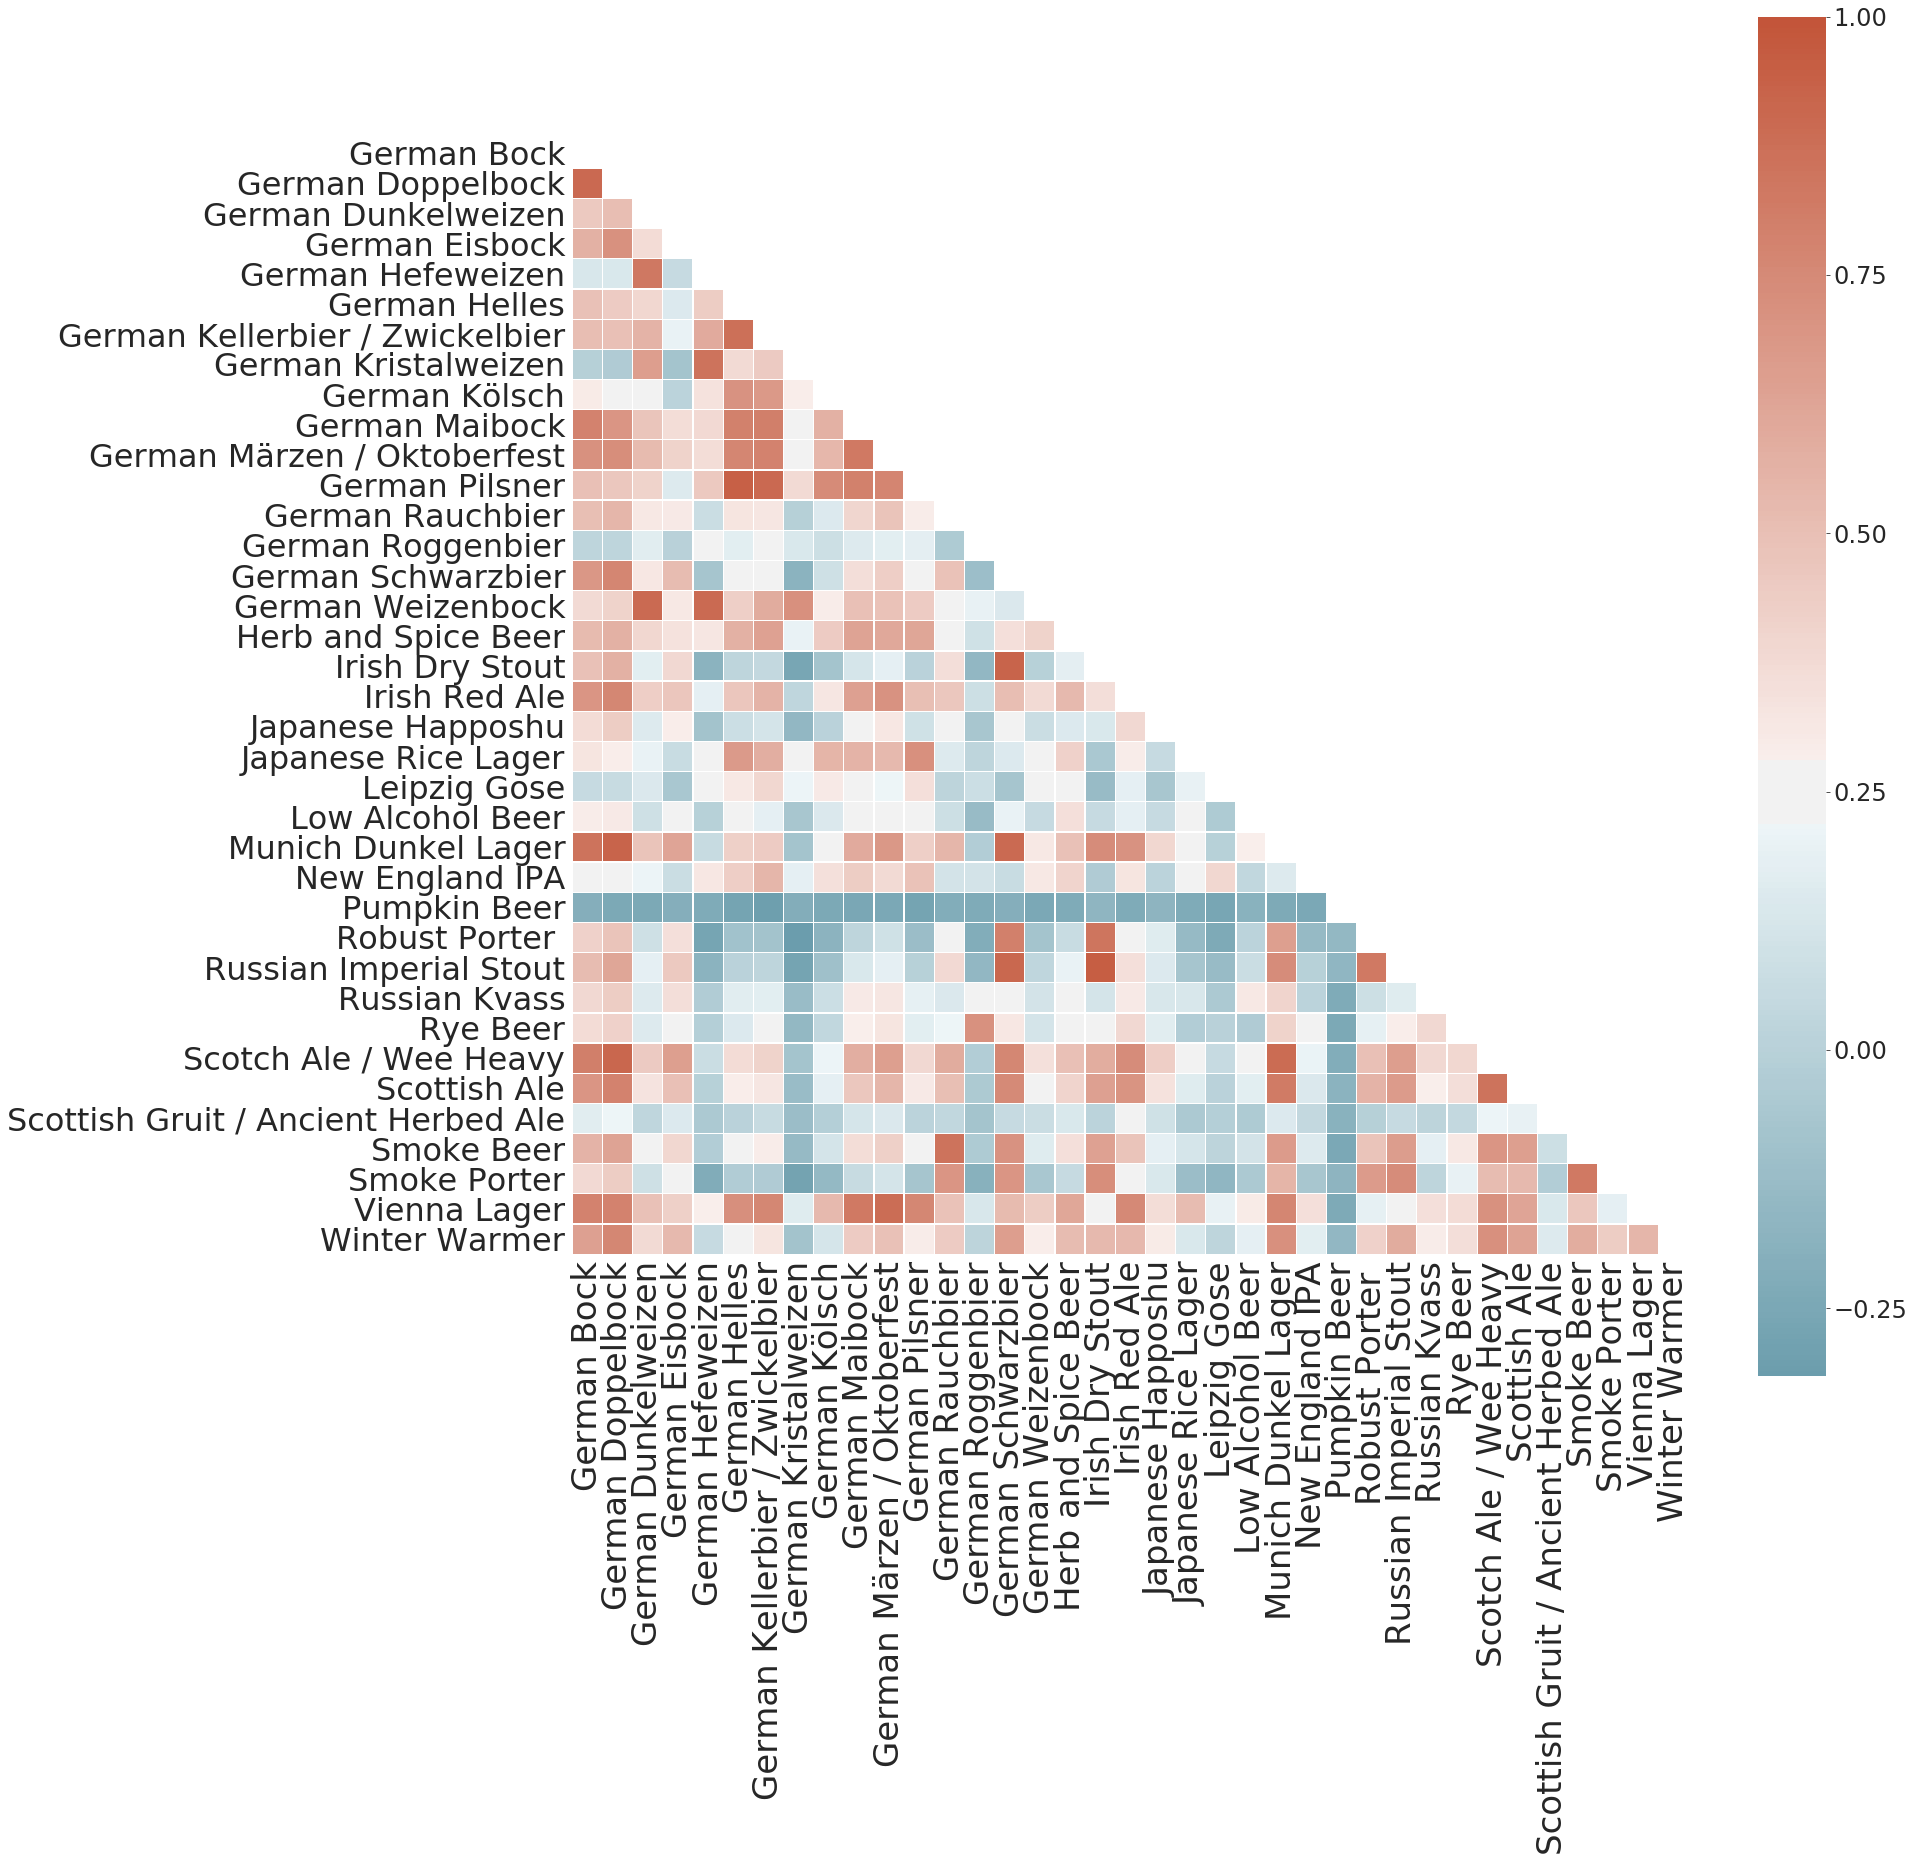

In [26]:
cos1 = X.dot(X.T)/(np.linalg.norm(X) * np.linalg.norm(X.T))
ind1 = 70
ind2 = 107
df = pd.DataFrame(cos1[ind1:ind2, ind1:ind2])
corr1 = df.corr()

#Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=10, as_cmap=True)
sns.set_style("whitegrid")

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, vmax=1.0, center=0.25, cmap=cmap,
            square=True, linewidths=.25, xticklabels= False)
ticks1 = list(range(df.shape[1]))
ticks1 = np.array(ticks1)
ticks1 = ticks1 + 0.5
plt.xticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=34, rotation=90)
plt.yticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=32, rotation = 0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

Pumpkin beers are really weird!!! They have essentially no similarity to other beers. We can also see that the German Kristalweizen which is a kind of sparkling wheat beer is also quite different to other beers. 

Let's do this for some other subset of beers. How about the first 50 which also include a lot of American beers? We can try another style to visualise the correlation instead of the triangle, which is output in the square matrix style. 

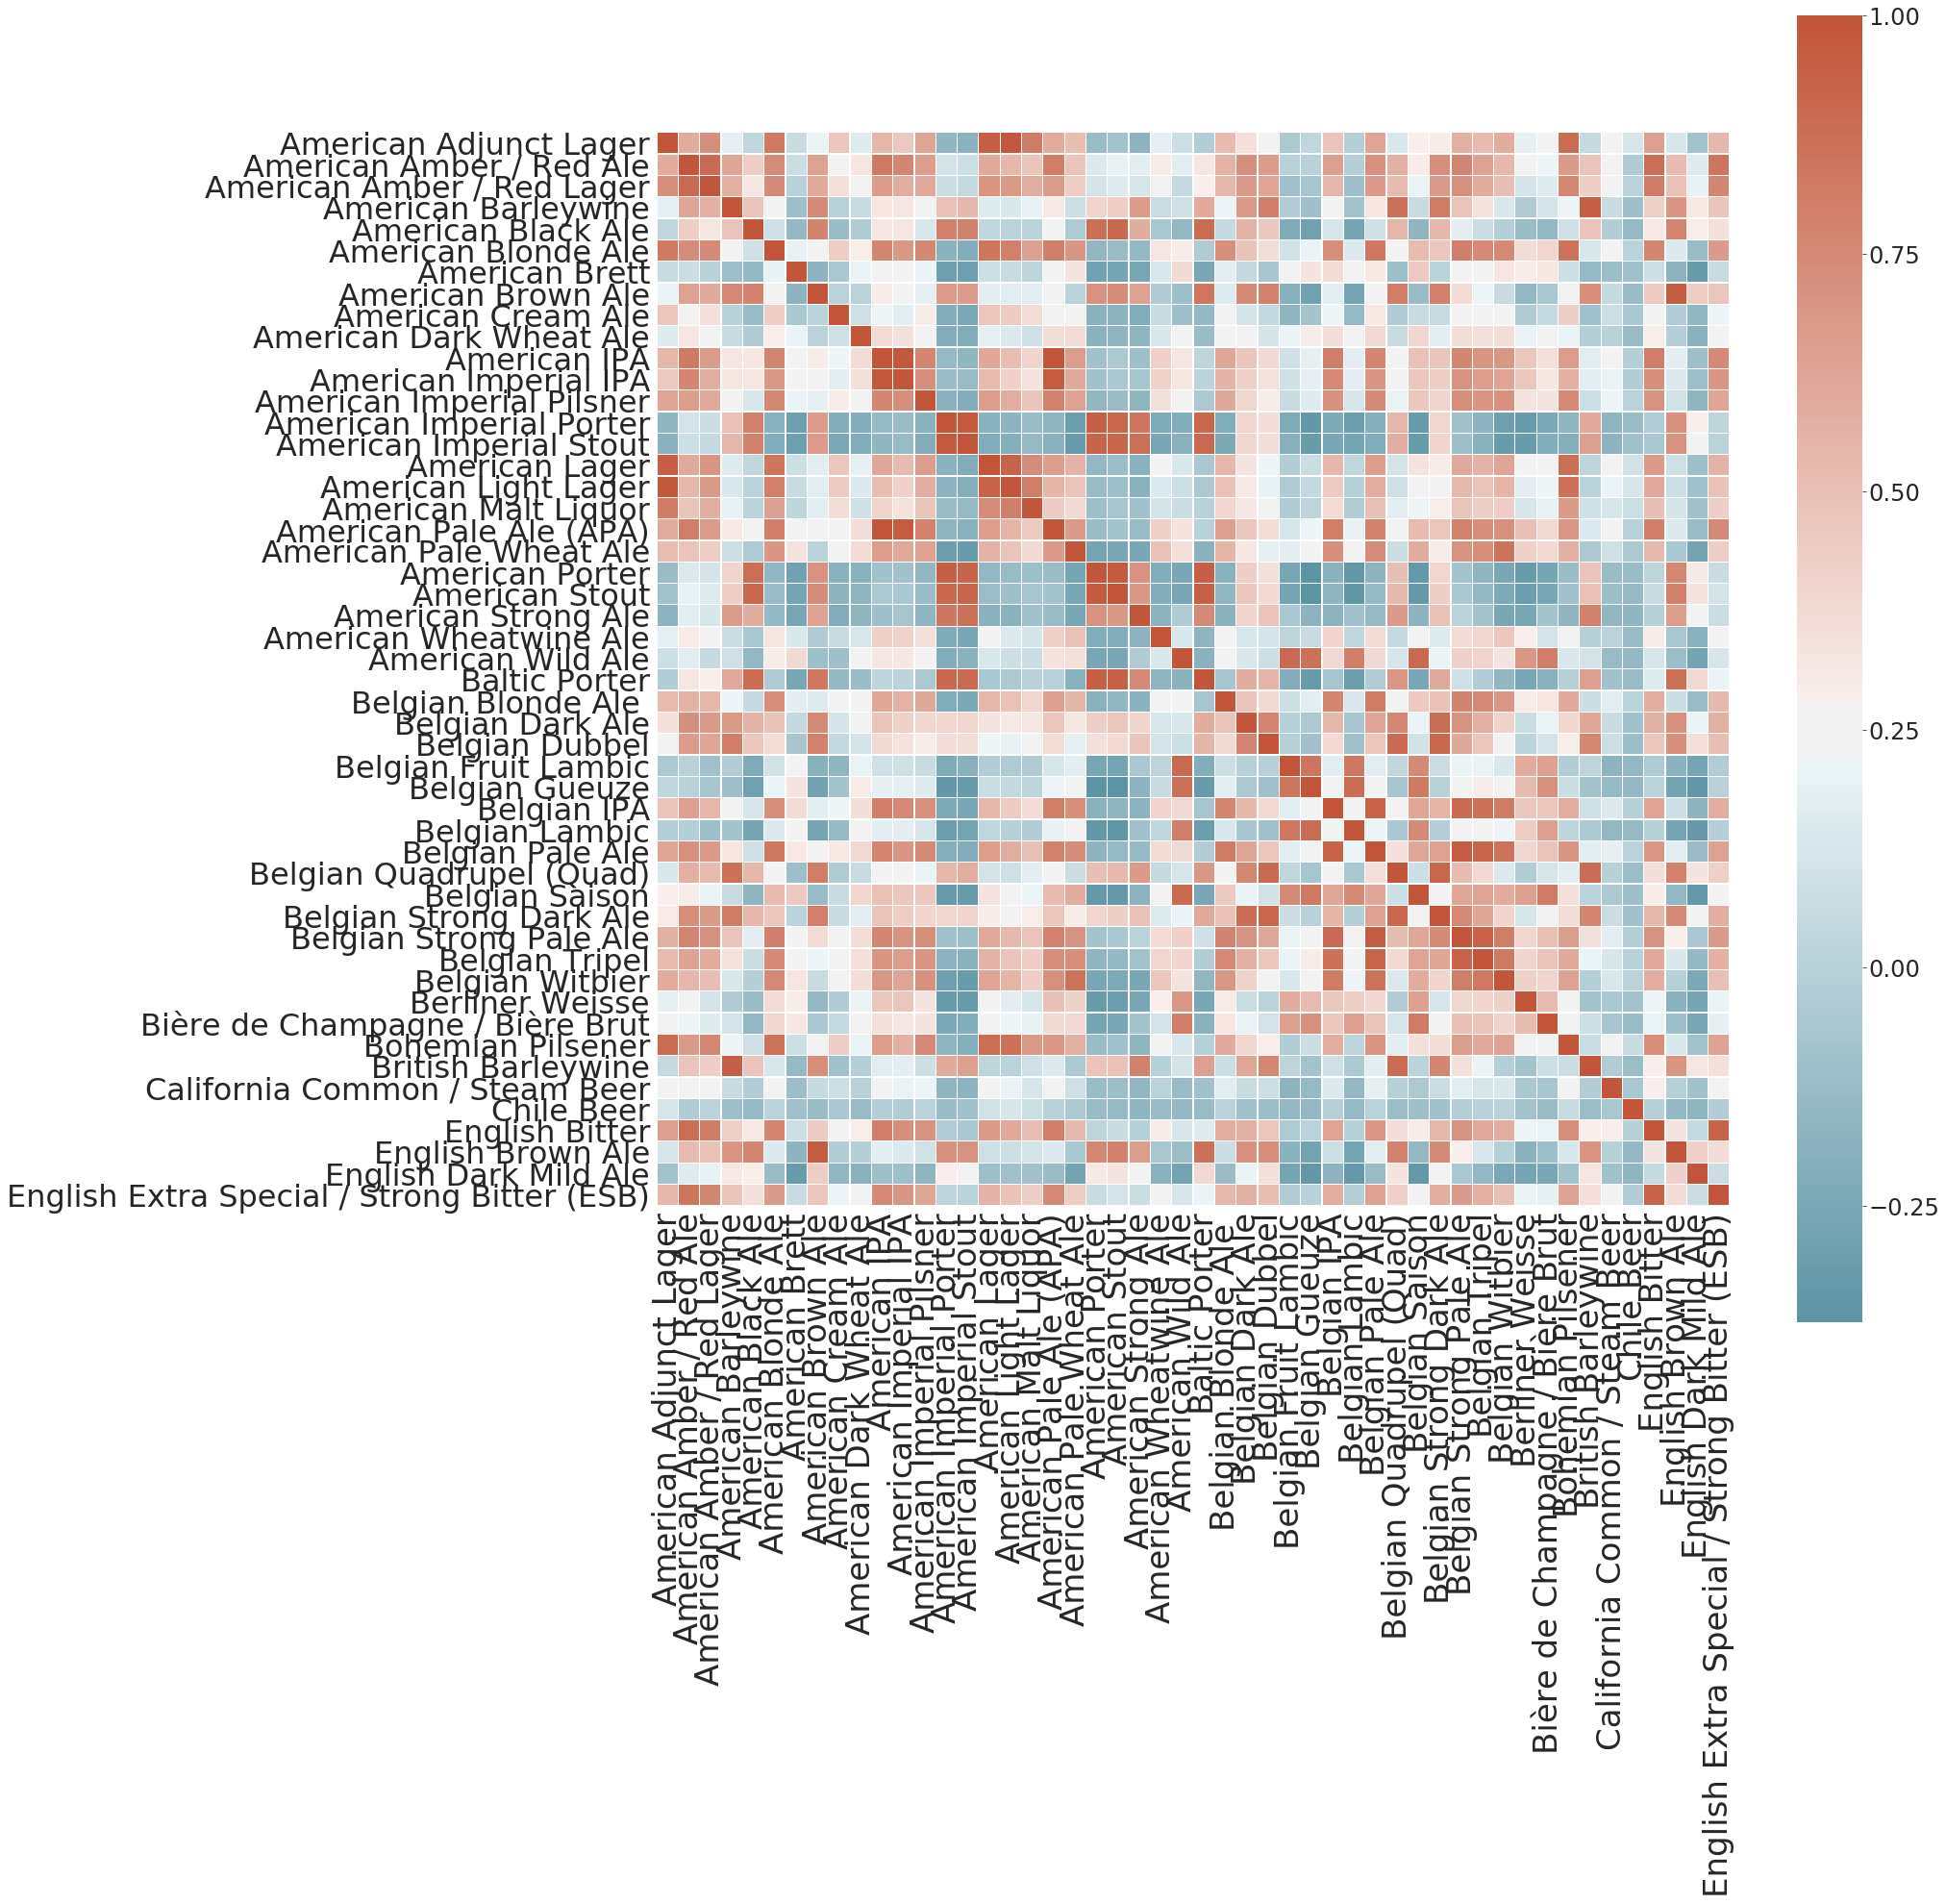

In [28]:
ind1 = 0
ind2 = 50
df = pd.DataFrame(cos1[ind1:ind2, ind1:ind2])
corr1 = df.corr()

#Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False


#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=10, as_cmap=True)
sns.set_style("whitegrid")

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, vmax=1.0, center=0.25, cmap=cmap,
            square=True, linewidths=.25, xticklabels= False)
ticks1 = list(range(df.shape[1]))
ticks1 = np.array(ticks1)
ticks1 = ticks1 + 0.5
plt.xticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=34, rotation=90)
plt.yticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=32, rotation = 0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

Porters and stouts seem to be very different from other beers! Anyone who has had these beers will probably know this to be true. We can also see that the Chile Beer is very different to the others, the Belgian beers are similar to each other as expected, and the American IPAs and Pilsners seem to be close to each other.

It would be interesting to see if we can group beer styles together now that we can see that some beers are more similar to others while some others are very dissimilar. How about a clustering plot?

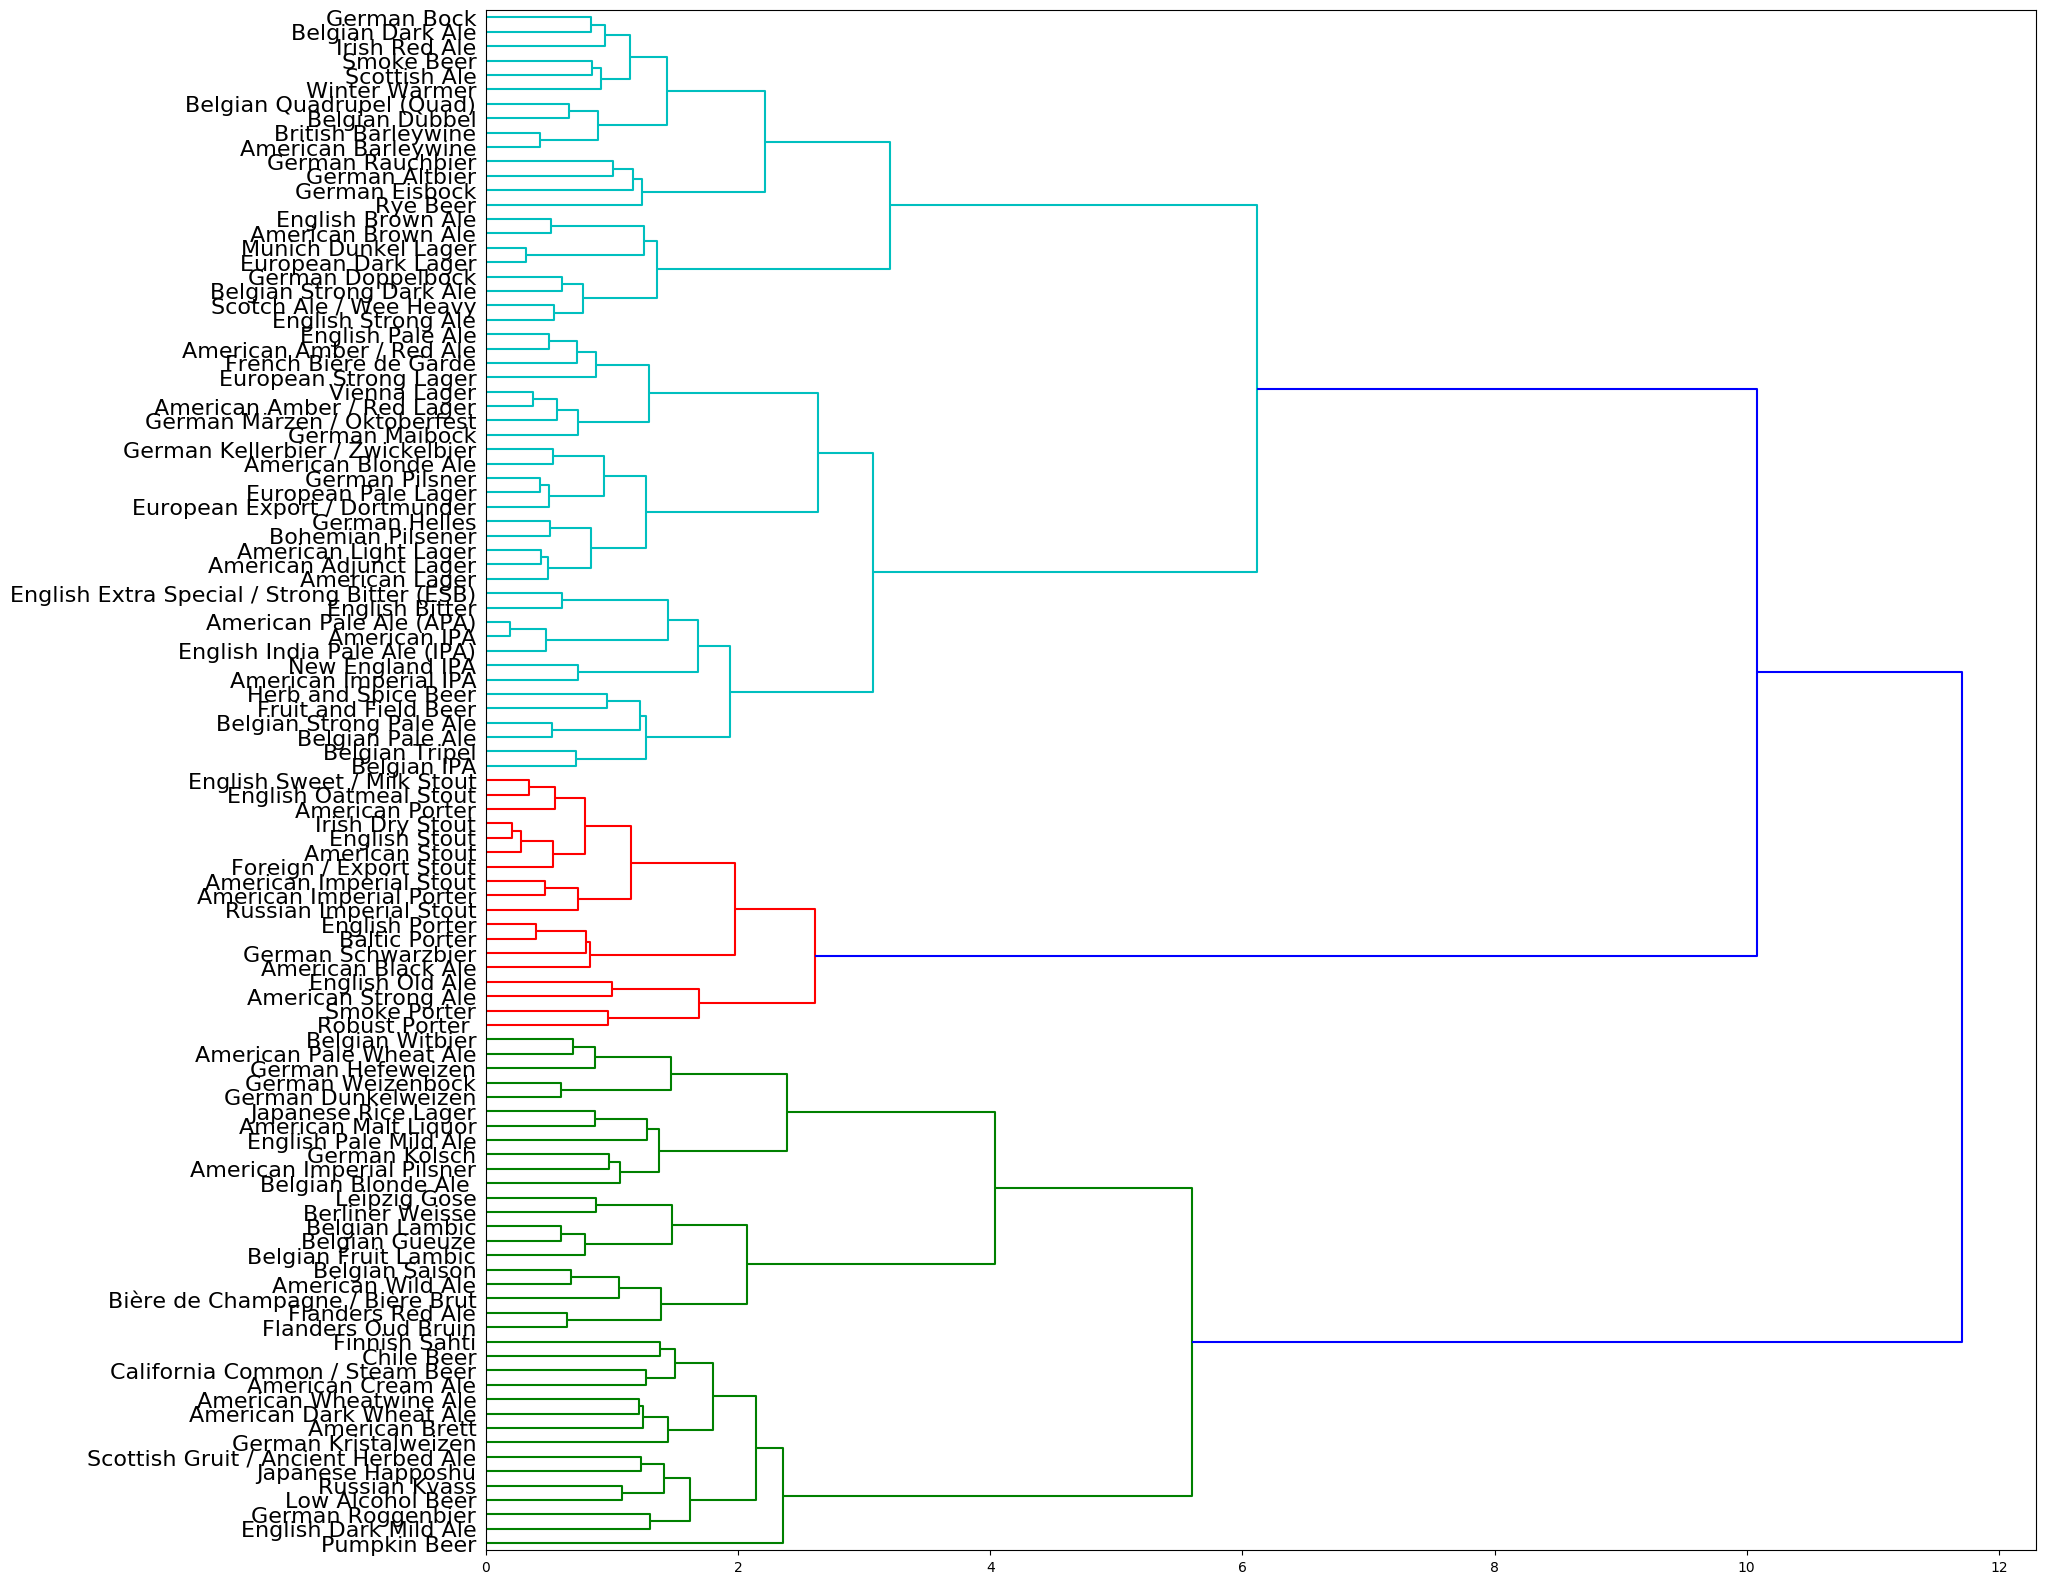

In [32]:
## Can we see how many groupings there are?
dist = 1 - cosine_similarity(X)
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
fig, ax = plt.subplots(figsize=(20, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels = list(grp1['drink_type']));
plt.yticks(fontsize=16)
plt.rcParams.update(plt.rcParamsDefault)



Interesting! There seem to be many different beer styles. Pumpkin beer is so different that it is its own style of beer! On a broad level however there seem to be 3 styles visible corresponding to 3 colours on the plot. These are approximately grouped by:

    1 - Belgians, wheat ales, and some of the more different beers like the Chile Beer and the low alcohol beer 
    which at the very least resemble wheat beers more than they resemble strong ales or IPAs
    2 - Stouts and Porters (as we saw previously these are just really distinct) and some strong ales
    3 - IPAs, Pilsners and Lagers, and the brown and red ales


Let's label each of the beer types in our data above with a cluster label.



In [34]:
cluster_results = fcluster(linkage_matrix,3,criterion='maxclust')
for item in np.unique(cluster_results):
    print(np.sum(cluster_results==item))

36
18
53


As we can see, we have a lot more of cluster 3, that is the Pilsner, Lagers, and IPAs, and the least number of beer types is in the Porters, Stouts, and Strong Ales grouping.

Let's add the cluster labels to our data frame in order to have labels for when we build the model.

In [35]:
data2 = grp1.copy()
data2['cluster_labels'] = list(cluster_results)
data2.head()

drink_type  ... cluster_labels
0      American Adjunct Lager  ...              3
1    American Amber / Red Ale  ...              3
2  American Amber / Red Lager  ...              3
3         American Barleywine  ...              3
4          American Black Ale  ...              2

[5 rows x 3 columns]

An interesting question from a prediction point of view now is, can we predict the beer style given it's review?
That is given the text of the review for a particular beer type, can we predict if the beer type in question falls into the grouping of IPAs, Pilsners, Lagers or in the grouping of Stouts and Porters or is a Belgian, wheat beer?

Let's split our 107 rows of data into train and test data. 

In [36]:
train_data, test_data = sklearn.model_selection.train_test_split(data2, test_size= 0.20)
train_data.head()

drink_type  ... cluster_labels
43   British Barleywine  ...              3
46       English Bitter  ...              3
92     Low Alcohol Beer  ...              1
59  European Dark Lager  ...              3
63        Finnish Sahti  ...              1

[5 rows x 3 columns]

In [0]:
vectorizer = TfidfVectorizer(stop_words='english', max_features = 5000)
X2 = vectorizer.fit_transform(train_data['reviews'])   #tfidf matrix for train data reviews
X3 = vectorizer.fit_transform(test_data['reviews'])    #tfidf matrix for test data reviews

We will use the KNeighbors Classifier to predict the grouping label. Our input data is the tfidf matrix for the reviews and our output is the cluster label. We want to maximise accuracy in the sense of accurately predicting the cluster labels that were assigned through the hierarchical clustering algorithm shown earlier. For more information on the KNeighbors Classifier see [here](https://scikit-learn.org/stable/modules/neighbors.html#classification).

In [42]:
n_neighbors = 3
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X2, train_data['cluster_labels'])
c2 = clf.predict(X3)
test_data.loc[:, 'predictions'] = list(c2)
accuracy = (test_data['cluster_labels'] == test_data['predictions']).sum() / len(test_data['cluster_labels'])
print(accuracy)

0.5454545454545454


Around 50% accuracy, not so great! Luckily, this is still better than 1/3 though which would be what we would have with random guessing.

---
#TODO: See our video to show how the map works, here's a nice visualization we created of average rating by country


In [104]:
def generate_csv(file_name, df):
      with open(file_name, mode='w') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        csv_writer.writerow(['COUNTRY', 'AVG RATING', 'CODE'])

        country_grouped = df.groupby('country')
        for country in country_grouped.groups.keys():
            total = 0
            count = 0
            for rating in country_grouped.get_group(country)['avg_rating']:
                total = total + float(rating)
                count = count + 1

            csv_writer.writerow([iso3166.countries_by_alpha2[country.upper()][0], total/count, iso3166.countries_by_alpha2[country.upper()][2]])
        
def plot_interactive_map(csv_data_file):
    df = pd.read_csv(csv_data_file)

    fig = go.Figure(data=go.Choropleth(
        locations = df['CODE'],
        z = df['AVG RATING'],
        text = df['COUNTRY'],
        colorscale = 'Reds',
        autocolorscale=False,
        reversescale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar_title = 'Average rating',
    ))

    fig.update_layout(
        title_text='Which country produces the best beers in the world?',
        geo=dict(
            showframe=False,
            showcountries=True,
            showcoastlines=True,
            projection_type='orthographic'
        ),
        annotations = [dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text="",
            showarrow = False
        )]
    )

    fig.show(renderer="notebook_connected")
beer_data = dataset.copy()
generate_csv('country_avg_ratings.csv', beer_data)
plot_interactive_map('country_avg_ratings.csv')

#TODO EXPLAIN how map works and visualization of breweries in the US

In [67]:
brewery_copy=openbrew_df.copy()
brewery_copy=brewery_copy.dropna()
origin_locations=brewery_copy[['latitude','longitude']]
#39.8283,-98.5795 are the coordinates for the geographical center of the USA
origin_locations=origin_locations.values.tolist()
types=brewery_copy["brewery_type"].tolist()
names=brewery_copy["name"].tolist()
colors=[]
for i in range(len(types)):
  type1=types[i]
  if type1=='micro':
    colors.append('red')
  elif type1 == 'regional':
    colors.append('blue')
  elif type1 == 'brewpub':
    colors.append('black')
  elif type1 == 'contract':
    colors.append('green')
  elif type1 == 'proprietor':
    colors.append('orange')
  elif type1 == 'large':
    colors.append('grey')
  elif type1 == 'bar':
    colors.append('pink')
  elif type1 == 'planning':
    colors.append('white')
def USAMap(default_location=[39.8283,-98.5795], default_zoom=5):
  usa_map = folium.Map(location=default_location,control_scale=True,zoom_start=default_zoom) #USAmap 
  return usa_map
starter_map = USAMap()

marker_cluster = folium.plugins.MarkerCluster().add_to(starter_map)
for i in range(1000):
  folium.Marker(origin_locations[i], popup=names[i]+'\n' + 'Type:' + types[i], icon=folium.Icon(color=colors[i], icon='beer', prefix = 'fa')).add_to(marker_cluster)
starter_map
